# This notebook attempts to review the AOD in the Latitude Longitude of Rupani, Nepal
## It is a scratch pad notebook

I will review the data, do some exploration, and write some functions and classes to go into a nicer noteboko. g
1.	Location of the plant with coordinates if possible  - 
Rupani, ward no 6, Rajbiraj, Madesh Pradesh, Nepal. 26 37’ 47” – N; 86 43’ 51” - E

THis is the precise corodinates of the kiln
Latitude 26°37′ 47″N is equivalent to 26°37.78333333333333′N (Degrees and decimal minutes).
Latitude 26°37′ 47″N is equivalent to 26.629722222222224° (Decimal degrees). 
Longitude 86°43′ 51″E is equivalent to 86°43.85′E (Degrees and decimal minutes). 
Longitude 86°43′ 51″E is equivalent to 86.73083333333334° (Decimal degrees).

Source: https://www.vercalendario.info/en/how/convert-latitude-longitude-degrees-decimals.html


To test this out, I downloaded a CSV version of the 0.1 pixel resolution file located at
https://neo.gsfc.nasa.gov/view.php?datasetId=MODAL2_M_AER_OD&date=2021-12-01
Actual CSV:
https://neo.gsfc.nasa.gov/servlet/RenderData?si=1814319&cs=rgb&format=CSV&width=3600&height=1800

In [91]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import sys

import gzip
import requests
from io import StringIO
import csv

import os

In [22]:
#Pick the date. 
date = '2021-09-22'

#Define the URL where the file is located. 
url = f'https://neo.gsfc.nasa.gov/archive/csv/MODAL2_D_AER_OD/MODAL2_M_AER_OD_{date}.CSV.gz'

#Download the file. 

myfile = requests.get(url)
if myfile.status_code == 404:
    sys.exit(f"Error! No such file found at this url: {url}")
    

#Now define the filename and directory where it will be downloaded. 
#Split and select the actual file's name. 
dl_file_name=url.split('/')[-1]
#Then add the directory name. 
dir1 = 'data//temp//'
file_dir=dir1+dl_file_name
#Now download it. 
open(file_dir, 'wb').write(myfile.content)

#Now decompress the file. 
my_filename=file_dir
file_name_out=my_filename[:-3]
with gzip.open(my_filename, 'rt') as gz_file:
    data = gz_file.read() # read decompressed data
    with open(file_name_out, 'wt') as out_file:
         out_file.write(data) # write decompressed data
#Finally, read it to a dataframe!
real_data= np.asarray(pd.read_csv(file_name_out))

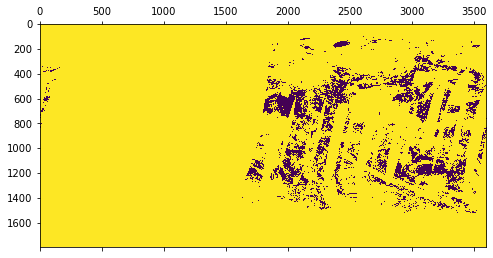

In [21]:
real_data.shape

#Take a look at the entire numpy array.
plt.matshow(real_data)

plt.show()

In [9]:
testfilename = 'data//MODAL2_M_AER_OD_2021-12-01_rgb_3600x1800.CSV'
geo_data_dec_2021 = pd.read_csv(testfilename)
geo_np = np.asarray(geo_data_dec_2021)
print(f"The shape of the numpy array is: {geo_np.shape}")

The shape of the numpy array is: (1799, 3600)


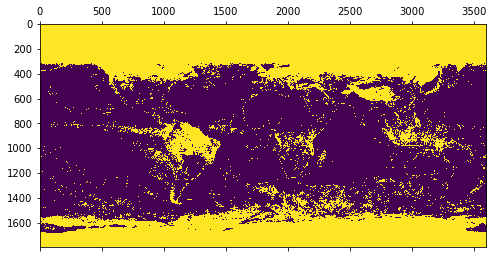

In [8]:
#Take a look at the entire numpy array.
plt.matshow(geo_np)

plt.show()

## Write a function to extract columns and rows near a certain latitude and longitude. 
Based on the appearance of the image, and the fact that this is a 0.1 degree resolution graphic, I Draw these conclusions:
* Rows correspond to the latitude. The maximum row, 1799, corresponds to latitude = -90 or 90 South. Each row corresponds to the top of the grid cell. Row 900 should then correspond to grid cells with a northern edge on the Equator. 
* Columns correspond to the longitude, starting at the antimeridian (180 W Longitude) and ending back at the antimerdian. Column #1800 is the prime meridian passing throuhg Greenwich. 

In [17]:
#Write a function to pull the cell in which the given latitude, longitude, is present. 
#lat, lon are the coordinates. They must be in decimal degrees such that 90 N= 90 latitude, 90 S = -90, 180W = +180 longitude, etc.
#res is the resolution (in degrees) of the file, defaulted to 0.1
def find_cell(lat,lon, res=0.1):
    #Convert latitude/longitude to the right coordinates
    row_lat = -lat/res +90/res
    row_lon = lon/res + 180/res
    return int(row_lat),int(row_lon)

#Rest some values
tests = [[0,0],[90,0],[-90,0],[0,180],[0,-180]]
for lat, lon in tests:
    print(f"Latitude/Longitude is actually {lat} {lon}")
    print(f"Your function gave it these rows: {find_cell(lat,lon)}")

Latitude/Longitude is actually 0 0
Your function gave it these rows: (900, 1800)
Latitude/Longitude is actually 90 0
Your function gave it these rows: (0, 1800)
Latitude/Longitude is actually -90 0
Your function gave it these rows: (1800, 1800)
Latitude/Longitude is actually 0 180
Your function gave it these rows: (900, 3600)
Latitude/Longitude is actually 0 -180
Your function gave it these rows: (900, 0)


# Find a subset of coordinates - start with West Coast USA
Emervyille, CA coordinates:  37.831318 , and the longitude is -122.285248 . 
The state of California is approximately 10 degrees latitude from north to south, so use 5 degrees as the buffer.

In [182]:
#Creates an object which pulls the data surrounding a given grid point.
#date is the date, which needs to be a string formatted like 'YYYY-MM', or it will not work. 

class AOD_Analysis:
    def __init__(self,date,lat, lon, size):
        #This is the no data value, which replaces 9999 with a different value
        #making plotting easier
        self.nodataval=-.1
        #Load the file.
        #geo_data = pd.read_csv(filename)
        self.date = date
        self.all_geo_np = self.file_download_to_np()
        self.all_geo_np = np.where(self.all_geo_np > 999, self.nodataval, self.all_geo_np)
        self.trimmed_geo_np = self.trim_aod(lat,lon,size)
        self.lat=lat
        self.lon=lon
        
        #Evaluate the average of the trimmed file, which is a key output.
        
        self.average=np.nanmean(np.where(self.trimmed_geo_np == self.nodataval, np.nan, self.trimmed_geo_np))
    
    def file_download_to_np(self):
      
        #Define the URL where the file is located. 
        url = f'https://neo.gsfc.nasa.gov/archive/csv/MODAL2_M_AER_OD/MODAL2_M_AER_OD_{self.date}.CSV.gz'

        #Download the file. 
        myfile = requests.get(url)
        if myfile.status_code == 404:
            print(f"Error! No such file found at this url: {url}")
            print("You entered a date incorrectly. Make sure the format is YYYY-MM-DD")
            sys.exit(f"HTTP Error {myfile_status_code}")

        #Now define the filename and directory where it will be downloaded. 
        #Split and select the actual file's name. 
        dl_file_name=url.split('/')[-1]
        #Then add the directory name. 
        dir1 = 'data//temp//'
        file_dir=dir1+dl_file_name
        
        #Now download it. 
        open(file_dir, 'wb').write(myfile.content)
        
        #Now decompress the file. 
        my_filename=file_dir
        file_name_out=my_filename[:-3]
        with gzip.open(my_filename, 'rt') as gz_file:
            data = gz_file.read() # read decompressed data
            with open(file_name_out, 'wt') as out_file:
                out_file.write(data) # write decompressed data    
        
        #Finally, read it to a dataframe!
        real_data= np.asarray(pd.read_csv(file_name_out))

        return(real_data)
    
    
    #Write a function to pull the cell in which the given latitude, longitude, is present. 
    #lat, lon are the coordinates. They must be in decimal degrees such that 90 N= 90 latitude, 90 S = -90, 180W = +180 longitude, etc.
    #res is the resolution (in degrees) of the file, defaulted to 0.1
    def find_cell(self,lat,lon, res=0.1):
        #Convert latitude/longitude to the right coordinates
        row_lat = -lat/res +90/res
        row_lon = lon/res + 180/res
        return int(row_lat),int(row_lon)
    
    #This function extracts the AOD centered on a given lat, lon
    #The lat,lon, are decimal latitude longtidue that will be the center of the grid point
    #size is the number of grid points to include
    def trim_aod(self,lat,lon,size):
        #Make the conversion
        lat_row,lon_row=self.find_cell(lat,lon)
        no_cells = int(size) 
        trimmed_aod = self.all_geo_np[(lat_row-no_cells):(lat_row+no_cells),(lon_row-no_cells):(lon_row+no_cells)]

        return trimmed_aod
    
    #Print chart
    #if trimmed=True, show only the trimmed version
    def show_map(self,trimmed=True):
        
        if trimmed != True:
            shower = self.all_geo_np
            #shower = np.where(self.all_geo_np > 99, -1, self.all_geo_np)
        if trimmed == True:
            shower = self.trimmed_geo_np
            #shower = np.where(self.trimmed_geo_np > 99, -1, self.trimmed_geo_np)
        plt.rcParams["figure.figsize"] = [8, 6]
        plt.rcParams["figure.autolayout"] = True
        im=plt.imshow(shower,cmap='copper')
        cbar = plt.colorbar(im)
        cbar.set_label(f"Aerosol Optical Depth Value ({self.nodataval} is no data)")
        plt.show()
    
    #Print histrogram of all values containing data
    #if trimmed=True, show only the trimmed version
    def show_hist(self,trimmed=True):
        if trimmed != True:
            shower = self.all_geo_np
        if trimmed == True:
            shower = self.trimmed_geo_np
            
        #shower = shower[shower < 999]
        fig,ax = plt.subplots(1,1)
        ax.hist(shower.ravel(),bins=100,density=False)
        ax.set_title(f"Histogram of AOD Centered on {round(self.lat,1)},{round(self.lon,1)}  ({self.nodataval} is no data)")
        
        ax.set_xlabel(f'Aerosol Optical Depth ({self.nodataval} is no data)')
        ax.set_ylabel('Count')
        plt.show()
    
    #Delete the files, since now that you have read them to Pandas, you are done. 
    def delete_temp_aod(self):
        dirname='data//temp//'
        for file in os.listdir(dirname):
            #os.close(dirname+file)
            os.remove(dirname+file)
         

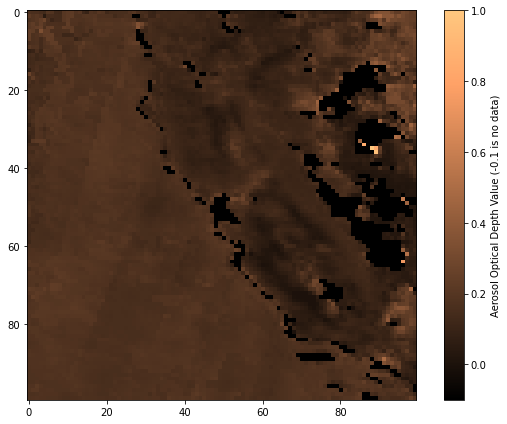

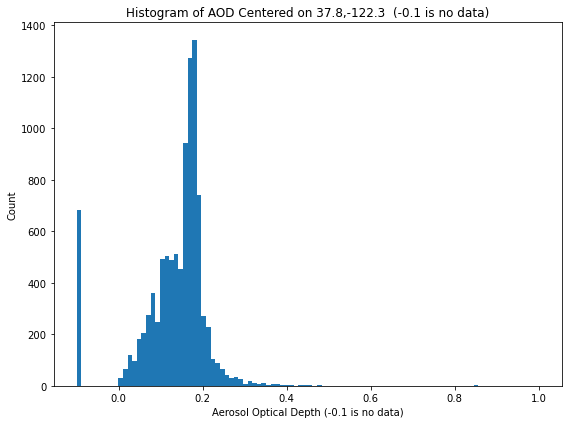

The average Aerosol Optical Depth was 0.14978922966734629


In [183]:
#Show emeryville
test = AOD_Analysis('2012-05',37.831318,-122.285248,5*10)
test.show_map()
test.show_hist()
#test.delete_temp_aod()
print(f"The average Aerosol Optical Depth was {test.average}")

### Now See Rupani

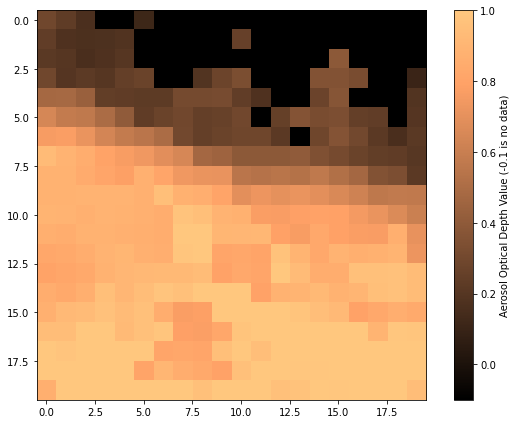

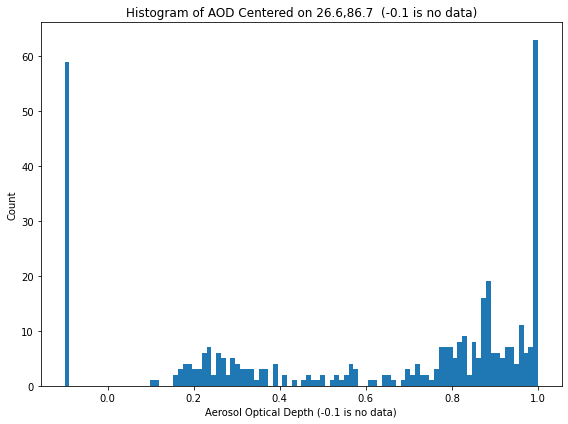

In [83]:
#Show a pixels degree size block
pixels = 10 #(1 degree for ar esolution of 0.1)

rupani = AOD_Analysis('2022-02',26.629722222222224,86.73083333333334,pixels)
rupani.show_map()
rupani.show_hist()



In [113]:
#Scan some time.
#years is a list of years you want to scan.
#lati,longi are the latitude and longitude to be centered upon.
#pixels is the number of pixels on each side of the center point to include.
#Since the downloaded files are 
def scan_over_time(years,lati,longi,degrees=1):
    #you will scan over all months.
    months = np.arange(1,13)
    #The resolution of all the files downloaded is 0.1 degrees, so multiply by ten to get pixels.
    pixels=degrees*10
    #The pandas dataframe to be returned. 
    vals = pd.DataFrame(columns=['Month','Average AOD'])
    for year in years:
        for month in months:
            #Create the string, which means that you have to account for whether or not there should be a 0 value. 
            if month <10: date = f'{year}-0{month}'
            if month >=10:  date = f'{year}-{month}'
            print(f'Downloading and processing MODIS AOD dataset centered on lat/lon {round(lati,1)}, {round(longi,1)} in the month {date}')
            inter = AOD_Analysis(date,ruplat,ruplon,50)
            print("Download and processing completed!")
            added = pd.DataFrame(data={'Month':[date],'Average AOD':[inter.average]})
            
            vals = vals.append(added)
    return vals

Download and processing completed!
Download and processing completed!
Download and processing completed!
Download and processing completed!
Download and processing completed!
Download and processing completed!
Download and processing completed!
Download and processing completed!
Download and processing completed!
Download and processing completed!
Download and processing completed!
Download and processing completed!
     Month  Average AOD
0  2015-01     0.536679
0  2015-02     0.646204
0  2015-03     0.383729
0  2015-04     0.489341
0  2015-05     0.612247
0  2015-06     0.598824
0  2015-07     0.469004
0  2015-08     0.713001
0  2015-09     0.445132
0  2015-10     0.464271
0  2015-11     0.571723
0  2015-12     0.679636


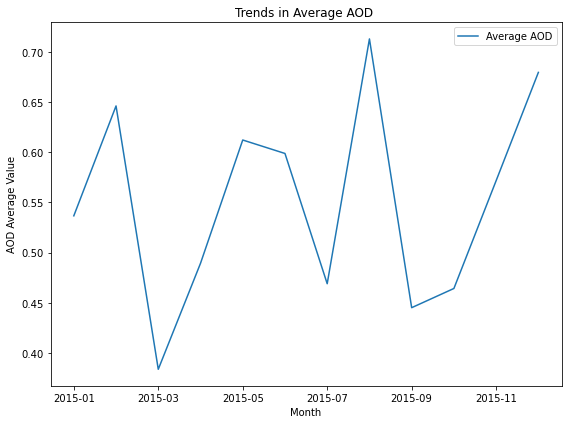

In [112]:
#Now see what it's like over the course of one year.
years = [2013,2014,2015,2016]
months = np.arange(1,13)

ruplat=26.629722222222224
ruplon=86.73083333333334
data=scan_over_time([2015],ruplat,ruplon)
data.plot(x='Month',y='Average AOD',
          title=f"Trends in Average AOD ",
         xlabel="Month",ylabel="AOD Average Value")
print(data)

In [104]:
for year in years:
    for month in months:
        #Create the string, which means that you have to account for whether or not there should be a 0 value. 
        if month <10: date = f'{year}-0{month}'
        if month >=10:  date = f'{year}-{month}'
        print(f'Downloading and processing {round(ruplat,1)}, {round(ruplon,1)} in the month {date}')
        inter = AOD_Analysis(date,ruplat,ruplon,50)
        print("Download and processing completed!")
        added = pd.DataFrame(data={'Month':[date],'Average AOD':[inter.average]})
        #vals = vals + [inter.average]
        vals = vals.append(added)

Download and processing completed!
Download and processing completed!
Download and processing completed!
Download and processing completed!
Download and processing completed!
Download and processing completed!
Download and processing completed!
Download and processing completed!
Download and processing completed!
Download and processing completed!
Download and processing completed!
Download and processing completed!
Download and processing completed!
Download and processing completed!
Download and processing completed!
Download and processing completed!
Download and processing completed!
Download and processing completed!
Download and processing completed!
Download and processing completed!
Download and processing completed!
Download and processing completed!
Download and processing completed!
Download and processing completed!
Download and processing completed!
Download and processing completed!
Download and processing completed!
Download and processing completed!
Download and process

     Month  Average AOD
0  2013-01     0.633340
0  2013-02     0.415881
0  2013-03     0.429339
0  2013-04     0.481555
0  2013-05     0.490544
0  2013-06     0.580230
0  2013-07     0.309354
0  2013-08     0.386820
0  2013-09     0.431504
0  2013-10     0.541205
0  2013-11     0.499674
0  2013-12     0.590445
0  2014-01     0.601109
0  2014-02     0.473088
0  2014-03     0.404113
0  2014-04     0.445824
0  2014-05     0.470549
0  2014-06     0.650920
0  2014-07     0.672466
0  2014-08     0.643144
0  2014-09     0.499922
0  2014-10     0.441379
0  2014-11     0.591277
0  2014-12     0.488540
0  2015-01     0.536679
0  2015-02     0.646204
0  2015-03     0.383729
0  2015-04     0.489341
0  2015-05     0.612247
0  2015-06     0.598824
0  2015-07     0.469004
0  2015-08     0.713001
0  2015-09     0.445132
0  2015-10     0.464271
0  2015-11     0.571723
0  2015-12     0.679636
0  2016-01     0.678783
0  2016-02     0.711304
0  2016-03     0.486727
0  2016-04     0.480099
0  2016-05     0

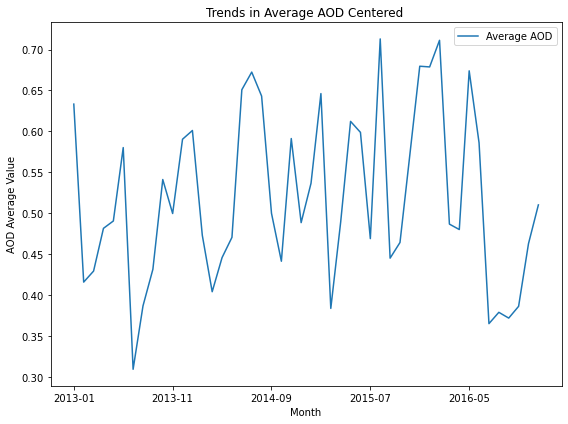

In [106]:
vals.plot(x='Month',y='Average AOD',
          title=f"Trends in Average AOD Centered ",
         xlabel="Month",ylabel="AOD Average Value")
print(vals)

In [262]:
import gdal


#Define file location
date = '2000-05-25'
print(date)
date_check = pd.to_datetime(date).to_julian_date()
date_check_2=date_check+1
date =pd.to_datetime(date_check_2,origin='julian',unit='D')
dater = f'{date.year}-{date.month}-{date.day}'
#date_check + 1


print(date_check)
print(date_check_2)
print(dater)

2000-05-25
2451689.5
2451690.5
2000-5-26


In [266]:
date = '2000-06-02'
dates = [date]
for day in np.arange(0,8):
    print(day)
    date_check = pd.to_datetime(date).to_julian_date()
    date_check_2=date_check+1
    date =pd.to_datetime(date_check_2,origin='julian',unit='D')
    dater = f'{date.year}-{date.month}-{date.day}'
    dates = dates + [dater]
print(dates)

0
1
2
3
4
5
6
7
['2000-06-02', '2000-6-3', '2000-6-4', '2000-6-5', '2000-6-6', '2000-6-7', '2000-6-8', '2000-6-9', '2000-6-10']


In [288]:
#Define file location
date = '2010-06-05'
#You need to check there is actually an 8-day file here.
dates = [date]
for day in np.arange(0,8):
    date_check = pd.to_datetime(date).to_julian_date()
    date_check_2=date_check+1
    date =pd.to_datetime(date_check_2,origin='julian',unit='D')
    #Create the string, which means that you have to account for whether or not there should be a 0 value. 
    if date.month <10: month = f'0{date.month}'
    if date.month >=10:  month = f'{date.month}'
    if date.day <10: day = f'0{date.day}'
    if date.day >=10:  day = f'{date.day}'
    dater = f'{date.year}-{month}-{day}'
    dates = dates + [dater]

for usable_date in dates:
    urltest=f"https://neo.gsfc.nasa.gov/archive/geotiff.float/MODAL2_E_AER_OD/MODAL2_E_AER_OD_{usable_date}.FLOAT.TIFF"
    myfile = requests.get(urltest)
    #print(f'The HTTP status code for {urltest} is {myfile.status_code}')
    if myfile.status_code == 200: 
        
        url = urltest
        print(f"File located for date {usable_date} at {url}!")
        
    
#Now define the filename and directory where it will be downloaded. 
#Split and select the actual file's name. 
dl_file_name=url.split('/')[-1]
#Then add the directory name. 
dir1 = 'data//temp//'
file_dir=dir1+dl_file_name
myfile = requests.get(url)
#Now download it. 
open(file_dir, 'wb').write(myfile.content)
print(f"File downloaded to {file_dir}")
raster = gdal.Open(file_dir)

# Check type of the variable 'raster' and continue if it loads. 
if (type(raster) == gdal.Dataset):
    print("Success! The file was successfully downloaded!")
    print("File type: "+str(type(raster)))

    # Pull out the bands. There's only one MODIS datasets covering AOD. 
    band1 = raster.GetRasterBand(1) # This raster only has one channel. 
    #Then convert them to numpy aarrays.
    b1 = band1.ReadAsArray()  
    print(band1.ReadAsArray())
if (type(raster) != gdal.Dataset):
    print("Failure! The file could not be loaded from "+file_dir)       

File located for date 2010-06-10 at https://neo.gsfc.nasa.gov/archive/geotiff.float/MODAL2_E_AER_OD/MODAL2_E_AER_OD_2010-06-10.FLOAT.TIFF!
File downloaded to data//temp//MODAL2_E_AER_OD_2010-06-10.FLOAT.TIFF
Success! The file was successfully downloaded!
File type: <class 'osgeo.gdal.Dataset'>
[[99999. 99999. 99999. ... 99999. 99999. 99999.]
 [99999. 99999. 99999. ... 99999. 99999. 99999.]
 [99999. 99999. 99999. ... 99999. 99999. 99999.]
 ...
 [99999. 99999. 99999. ... 99999. 99999. 99999.]
 [99999. 99999. 99999. ... 99999. 99999. 99999.]
 [99999. 99999. 99999. ... 99999. 99999. 99999.]]


In [302]:
#Creates an object which pulls the data surrounding a given grid point.
#date is the date, which needs to be a string formatted like 'YYYY-MM', or it will not work. 

class AOD_Analysis_1:
    def __init__(self,date,lat, lon, size):
        #This is the no data value, which replaces 9999 with a different value
        #making plotting easier
        self.nodataval=-.1
        #Load the file.
        #geo_data = pd.read_csv(filename)
        self.date = date
        self.all_geo_np = self.file_download_to_np()
        self.all_geo_np = np.where(self.all_geo_np > 999, self.nodataval, self.all_geo_np)
        self.trimmed_geo_np = self.trim_aod(lat,lon,size)
        self.lat=lat
        self.lon=lon
        
        #Evaluate the average of the trimmed file, which is a key output.
        
        self.average=np.nanmean(np.where(self.trimmed_geo_np == self.nodataval, np.nan, self.trimmed_geo_np))
    
    def file_download_to_np(self):
      
        #Define file location
        
        #You need to check there is actually an 8-day file here.
        dates = [self.date]
        for day in np.arange(0,8):
            date_check = pd.to_datetime(self.date).to_julian_date()
            date_check_2=date_check+day
            date1 =pd.to_datetime(date_check_2,origin='julian',unit='D')
            #Create the string, which means that you have to account for whether or not there should be a 0 value. 
            if date1.month <10: month = f'0{date1.month}'
            if date1.month >=10:  month = f'{date1.month}'
            if date1.day <10: day = f'0{date1.day}'
            if date1.day >=10:  day = f'{date1.day}'
            dater = f'{date1.year}-{month}-{day}'
            dates = dates + [dater]

        for usable_date in dates:
            urltest=f"https://neo.gsfc.nasa.gov/archive/geotiff.float/MODAL2_E_AER_OD/MODAL2_E_AER_OD_{usable_date}.FLOAT.TIFF"
            myfile = requests.get(urltest)
            print(f'The HTTP status code for {urltest} is {myfile.status_code}')
            if myfile.status_code == 200: 

                url = urltest
                print(f"File located for date {usable_date} at {url}!")


        #Now define the filename and directory where it will be downloaded. 
        #Split and select the actual file's name. 
        dl_file_name=url.split('/')[-1]
        #Then add the directory name. 
        dir1 = 'data//temp//'
        file_dir=dir1+dl_file_name
        myfile = requests.get(url)
        #Now download it. 
        open(file_dir, 'wb').write(myfile.content)
        print(f"File downloaded to {file_dir}")
        raster = gdal.Open(file_dir)

        # Check type of the variable 'raster' and continue if it loads. 
        if (type(raster) == gdal.Dataset):
            print("Success! The file was successfully downloaded!")
            print("File type: "+str(type(raster)))

            # Pull out the bands. There's only one MODIS datasets covering AOD. 
            band1 = raster.GetRasterBand(1) # This raster only has one channel. 
            #Then convert them to numpy aarrays.
            real_data = band1.ReadAsArray()  
            
        if (type(raster) != gdal.Dataset):
            print("Failure! The file could not be loaded from "+file_dir)    

        return(real_data)
    
    
    #Write a function to pull the cell in which the given latitude, longitude, is present. 
    #lat, lon are the coordinates. They must be in decimal degrees such that 90 N= 90 latitude, 90 S = -90, 180W = +180 longitude, etc.
    #res is the resolution (in degrees) of the file, defaulted to 0.1
    def find_cell(self,lat,lon, res=0.1):
        #Convert latitude/longitude to the right coordinates
        row_lat = -lat/res +90/res
        row_lon = lon/res + 180/res
        return int(row_lat),int(row_lon)
    
    #This function extracts the AOD centered on a given lat, lon
    #The lat,lon, are decimal latitude longtidue that will be the center of the grid point
    #size is the number of grid points to include
    def trim_aod(self,lat,lon,size):
        #Make the conversion
        lat_row,lon_row=self.find_cell(lat,lon)
        no_cells = int(size) 
        trimmed_aod = self.all_geo_np[(lat_row-no_cells):(lat_row+no_cells),(lon_row-no_cells):(lon_row+no_cells)]

        return trimmed_aod
    
    #Print chart
    #if trimmed=True, show only the trimmed version
    def show_map(self,trimmed=True):
        
        if trimmed != True:
            shower = self.all_geo_np
            #shower = np.where(self.all_geo_np > 99, -1, self.all_geo_np)
        if trimmed == True:
            shower = self.trimmed_geo_np
            #shower = np.where(self.trimmed_geo_np > 99, -1, self.trimmed_geo_np)
        plt.rcParams["figure.figsize"] = [8, 6]
        plt.rcParams["figure.autolayout"] = True
        im=plt.imshow(shower,cmap='copper')
        cbar = plt.colorbar(im)
        cbar.set_label(f"Aerosol Optical Depth Value ({self.nodataval} is no data)")
        plt.show()
    
    #Print histrogram of all values containing data
    #if trimmed=True, show only the trimmed version
    def show_hist(self,trimmed=True):
        if trimmed != True:
            shower = self.all_geo_np
        if trimmed == True:
            shower = self.trimmed_geo_np
            
        #shower = shower[shower < 999]
        fig,ax = plt.subplots(1,1)
        ax.hist(shower.ravel(),bins=100,density=False)
        ax.set_title(f"Histogram of AOD Centered on {round(self.lat,1)},{round(self.lon,1)}  ({self.nodataval} is no data)")
        
        ax.set_xlabel(f'Aerosol Optical Depth ({self.nodataval} is no data)')
        ax.set_ylabel('Count')
        plt.show()

         

The HTTP status code for https://neo.gsfc.nasa.gov/archive/geotiff.float/MODAL2_E_AER_OD/MODAL2_E_AER_OD_2012-05-02.FLOAT.TIFF is 404
The HTTP status code for https://neo.gsfc.nasa.gov/archive/geotiff.float/MODAL2_E_AER_OD/MODAL2_E_AER_OD_2012-05-02.FLOAT.TIFF is 404
The HTTP status code for https://neo.gsfc.nasa.gov/archive/geotiff.float/MODAL2_E_AER_OD/MODAL2_E_AER_OD_2012-05-03.FLOAT.TIFF is 404
The HTTP status code for https://neo.gsfc.nasa.gov/archive/geotiff.float/MODAL2_E_AER_OD/MODAL2_E_AER_OD_2012-05-04.FLOAT.TIFF is 404
The HTTP status code for https://neo.gsfc.nasa.gov/archive/geotiff.float/MODAL2_E_AER_OD/MODAL2_E_AER_OD_2012-05-05.FLOAT.TIFF is 404
The HTTP status code for https://neo.gsfc.nasa.gov/archive/geotiff.float/MODAL2_E_AER_OD/MODAL2_E_AER_OD_2012-05-06.FLOAT.TIFF is 404
The HTTP status code for https://neo.gsfc.nasa.gov/archive/geotiff.float/MODAL2_E_AER_OD/MODAL2_E_AER_OD_2012-05-07.FLOAT.TIFF is 404
The HTTP status code for https://neo.gsfc.nasa.gov/archive/geo

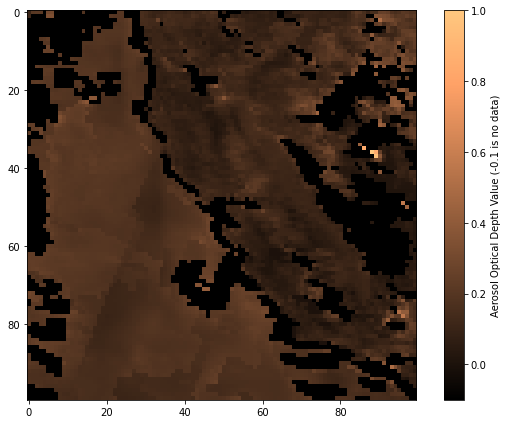

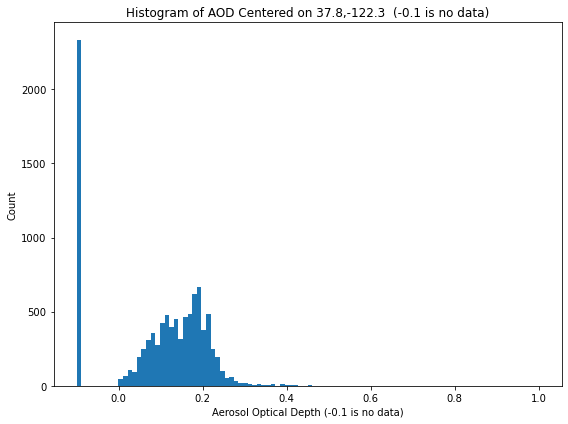

The average Aerosol Optical Depth was 0.1501583755016327


In [303]:
#Show emeryville
test = AOD_Analysis_1('2012-05-02',37.831318,-122.285248,5*10)
test.show_map()
test.show_hist()
#test.delete_temp_aod()
print(f"The average Aerosol Optical Depth was {test.average}")